In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
import numpy as np
import pandas as pd
import re
import string
import nltk
import gensim
import pickle
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk import punkt
from nltk import wordnet

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D,Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [3]:
data_columns = ["target", "ids", "date", "flag", "user", "text"]
data_encoding = "ISO-8859-1"
data=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv',encoding = data_encoding, names=data_columns)

In [4]:
data.sample(5)

,target,ids,date,flag,user,text
17623,0,1556351927,Sat Apr 18 22:30:36 PDT 2009,NO_QUERY,suzieqtx81,having trouble sleeping tonight for some reason.
343750,0,2015526105,Wed Jun 03 04:53:42 PDT 2009,NO_QUERY,shycai,i wanna run i need the exercise... anybody wa...
431477,0,2064551049,Sun Jun 07 06:34:28 PDT 2009,NO_QUERY,leahmstafford,@bobbiandmike i have a chair i bought @ a rumm...
946559,4,1822722853,Sat May 16 20:14:05 PDT 2009,NO_QUERY,thiswasandy,"Listening to some new music by Michael Warren,..."
294848,0,1996708184,Mon Jun 01 15:32:59 PDT 2009,NO_QUERY,swallow_elxsol,im taking a nap... text me if anything is hap...


In [5]:
data.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [6]:
X = data.iloc[:,[5]]
y = data.iloc[:,0]

In [7]:
y[y==4]=1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
def repair(tweet):
    username = "@\S+"
    new_tweet = re.sub(username, ' ',tweet) # Remove @tags
    
    new_tweet = new_tweet.lower() # Smart lowercase
    
    new_tweet = re.sub(r'\d+', ' ', new_tweet) # Remove numbers
    
    text_noise = "https?:\S+|http?:\S|[^A-Za-z0-9]+" 
    new_tweet = re.sub(text_noise, ' ', new_tweet) # Remove links
    
    new_tweet = new_tweet.translate(new_tweet.maketrans('','',string.punctuation)) # Remove Punctuation
    
    new_tweet = new_tweet.strip() # Remove white spaces
    
    new_tweet = word_tokenize(new_tweet) # Tokenize into words
    
    new_tweet = ' '.join([word for word in new_tweet if word.isalpha()]) # Remove non alphabetic tokens
    
    stop_words = set(stopwords.words('english'))
    new_tweet = ' '.join([word for word in new_tweet.split() if not word in stop_words]) # Filter out stop words
    
    lemmatizer = WordNetLemmatizer()
    new_tweet = ' '.join([lemmatizer.lemmatize(word,"v") for word in new_tweet.split()]) # Word Lemmatization
    
    return new_tweet

In [9]:
X['text']= X['text'].apply(repair)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 1280000
TEST size: 320000


In [11]:
w2v_size = 300
w2v_win = 7
w2v_epoch = 32
w2v_mincount = 10

document = [tweet.split() for tweet in X_train.text]
word2vec_model = gensim.models.word2vec.Word2Vec(vector_size=w2v_size,
                                                window=w2v_win,
                                                min_count=w2v_mincount,
                                                workers=8)

word2vec_model.build_vocab(document)

In [12]:
words = word2vec_model.wv.index_to_key
vocabulary_size = len(words)
print('Vocabulary_size ::: ',vocabulary_size)

Vocabulary_size :::  25276


In [13]:
word2vec_model.train(document,total_examples=len(document),epochs=w2v_epoch)

(251373403, 289225504)

In [14]:
word2vec_model.wv.most_similar("love")

[('amaze', 0.5868600606918335),
 ('luv', 0.5584689378738403),
 ('adore', 0.5458216071128845),
 ('awesome', 0.5256385207176208),
 ('looove', 0.4906412363052368),
 ('loooove', 0.44694218039512634),
 ('lt', 0.4395308196544647),
 ('loveee', 0.4329444468021393),
 ('loveeeee', 0.40848052501678467),
 ('incredible', 0.4024706184864044)]

In [15]:
word2vec_model.wv.most_similar("hatred")

[('insignificant', 0.3795170783996582),
 ('apathy', 0.3228535056114197),
 ('idiots', 0.3196958005428314),
 ('emotions', 0.3181428015232086),
 ('equality', 0.3171066641807556),
 ('satisfaction', 0.31670475006103516),
 ('hormones', 0.3156619966030121),
 ('anger', 0.3151332139968872),
 ('attitudes', 0.3129337728023529),
 ('humanity', 0.31014466285705566)]

In [16]:
max_sequence_length = 300
vector_size = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)
unique_tokens = tokenizer.word_index
tokens_size = len(unique_tokens)
print('No.of unique tokens === %s'%tokens_size)

No.of unique tokens === 232838


In [17]:
X_train_padded = tokenizer.texts_to_sequences(X_train.text)
X_train_padded = pad_sequences(X_train_padded,maxlen=max_sequence_length)


In [18]:
vector_matrix = np.zeros((tokens_size+1,w2v_size))

for word,i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        vector_matrix[i]=word2vec_model.wv[word]

print('vector matrix shape === ',vector_matrix.shape)

vector_matrix

vector matrix shape ===  (232839, 300)


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.28419626e-01, -8.15595746e-01, -2.76189726e-02, ...,
        -4.09158785e-03,  3.22293550e-01,  2.55045772e-01],
       [-8.72117747e-03, -5.22340473e-04, -5.74133456e-01, ...,
        -3.17462534e-01,  6.18526459e-01, -3.15392107e-01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [19]:
gru_model = Sequential()
gru_model.add(Embedding(tokens_size+1,w2v_size, weights=[vector_matrix],input_length=max_sequence_length,trainable=False))
gru_model.add(Dropout(0.3))
gru_model.add(Bidirectional(GRU(100,dropout=0.2,recurrent_dropout=0.2)))
gru_model.add(Dense(1,activation='sigmoid'))

2022-05-24 22:35:59.087314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 22:35:59.199203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 22:35:59.200281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-24 22:35:59.202607: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
gru_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
callbacks = [ReduceLROnPlateau(monitor='val_loss',patience=5,cooldown=0),
            EarlyStopping(monitor='val_accuracy',min_delta=1e-4,patience=5)]

bs = 1024

In [22]:
gru_history = gru_model.fit(X_train_padded,y_train,batch_size = bs, epochs=5,validation_split=0.1,verbose=1,callbacks=callbacks)

2022-05-24 22:36:02.414676: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1382400000 exceeds 10% of free system memory.
2022-05-24 22:36:03.473570: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1125/1125 [==============================] - 1025s 908ms/step - loss: 0.4966 - accuracy: 0.7552 - val_loss: 0.4656 - val_accuracy: 0.7764
Epoch 2/5
1125/1125 [==============================] - 1030s 915ms/step - loss: 0.4741 - accuracy: 0.7705 - val_loss: 0.4577 - val_accuracy: 0.7813
Epoch 3/5
1125/1125 [==============================] - 1038s 922ms/step - loss: 0.4681 - accuracy: 0.7744 - val_loss: 0.4540 - val_accuracy: 0.7835
Epoch 4/5
1125/1125 [==============================] - 1043s 926ms/step - loss: 0.4643 - accuracy: 0.7770 - val_loss: 0.4523 - val_accuracy: 0.7844
Epoch 5/5
1125/1125 [==============================] - 1051s 934ms/step - loss: 0.4618 - accuracy: 0.7780 - val_loss: 0.4502 - val_accuracy: 0.7859


In [23]:
gru_model.save('main_GRU_model.h5')
with open('main_GRU_history', 'wb') as file_pi:
    pickle.dump(gru_history.history, file_pi)

In [24]:
X_test_padded = tokenizer.texts_to_sequences(X_test.text)
X_test_padded = pad_sequences(X_test_padded, maxlen=max_sequence_length)
score = gru_model.evaluate(X_test_padded, y_test, batch_size=512)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

625/625 [==============================] - 111s 177ms/step - loss: 0.4485 - accuracy: 0.7874
ACCURACY: 0.7874218821525574
LOSS: 0.4485459327697754


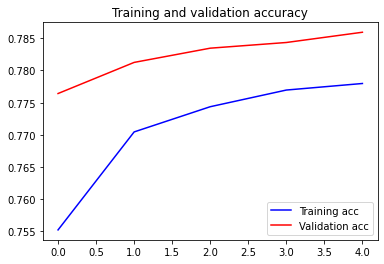

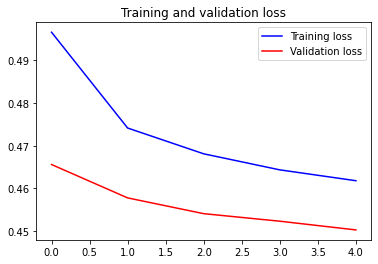

In [25]:
acc = gru_history.history['accuracy']
val_acc = gru_history.history['val_accuracy']
loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show(block=False)

In [26]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_sequence_length)
    # Predict
    score = gru_model.predict([x_test])[0]
    if(score >=0.50):
        label = "Positive"
    if(score <0.50):
        label = "Negative"

    return {"label" : label,
        "score": float(score)}  

In [27]:
predict("How u know u dont get real life pussy")

{'label': 'Negative', 'score': 0.42412254214286804}

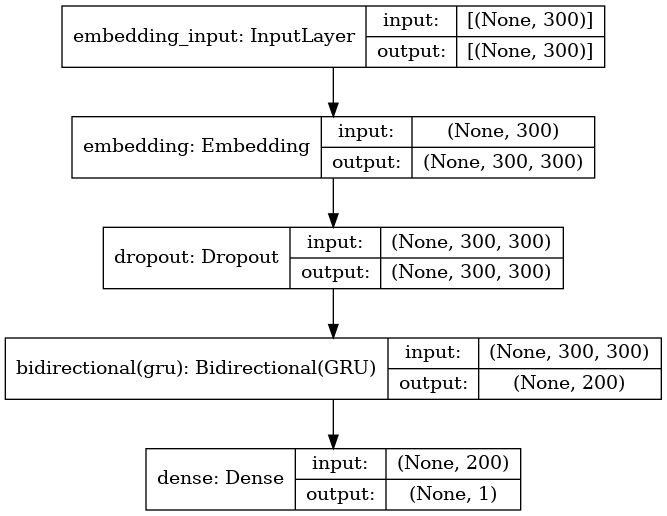

In [28]:
from keras.utils.vis_utils import plot_model

plot_model(gru_model,to_file='gru_model.png',show_layer_names=True, show_shapes=True)